# Import Libraries

In [19]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
tf.compat.v1.disable_eager_execution()

from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

from art.utils import load_cifar10
from art.estimators.classification import KerasClassifier
from art.attacks.evasion import AutoConjugateGradient

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import warnings
warnings.filterwarnings('ignore')

# Load Data

In [64]:
(x_train, y_train), (x_test, y_test), min_, max_ = load_cifar10()

# Model

In [29]:
def create_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation="relu", padding="same", input_shape=(32, 32, 3)),
        Conv2D(32, (3, 3), activation="relu", padding="same"),
        MaxPooling2D(pool_size=(2, 2)),
        
        Conv2D(64, (3, 3), activation="relu", padding="same"),
        Conv2D(64, (3, 3), activation="relu", padding="same"),
        MaxPooling2D(pool_size=(2, 2)),
        
        Flatten(),
        
        Dense(512, activation="relu"),
        Dense(10)
    ])
    model.compile(loss=SparseCategoricalCrossentropy(from_logits=True), optimizer="adam", metrics=["accuracy"])
    return model

In [30]:
model = create_model()

# Train

In [31]:
classifier = KerasClassifier(
    model=model,
    clip_values=(min_, max_),
    use_logits=False,
    preprocessing=(0.5, 1)
)

In [32]:
classifier.fit(x_train, y_train, nb_epochs=10, verbose=1)

Train on 50000 samples
Epoch 1/10
50000/50000 [==============================] - 3s 69us/sample - loss: 1.3500 - accuracy: 0.5145
Epoch 2/10
50000/50000 [==============================] - 3s 63us/sample - loss: 0.8957 - accuracy: 0.6845
Epoch 3/10
50000/50000 [==============================] - 3s 63us/sample - loss: 0.6944 - accuracy: 0.7570
Epoch 4/10
50000/50000 [==============================] - 3s 63us/sample - loss: 0.5338 - accuracy: 0.8147
Epoch 5/10
50000/50000 [==============================] - 3s 65us/sample - loss: 0.3809 - accuracy: 0.8693
Epoch 6/10
50000/50000 [==============================] - 3s 62us/sample - loss: 0.2374 - accuracy: 0.9179
Epoch 7/10
50000/50000 [==============================] - 4s 83us/sample - loss: 0.1442 - accuracy: 0.9501
Epoch 8/10
50000/50000 [==============================] - 3s 64us/sample - loss: 0.0817 - accuracy: 0.9730
Epoch 9/10
50000/50000 [==============================] - 3s 63us/sample - loss: 0.0710 - accuracy: 0.9764
Epoch 10/10
50

# Attack

In [33]:
art_model = KerasClassifier(
    model=model, 
    clip_values=(min_, max_),
    use_logits=False,
    preprocessing=(0.5, 1)
)

In [62]:
conjugate_gradient = AutoConjugateGradient(art_model, norm=1, targeted=False, eps=0.6, eps_step=0.1, max_iter=25)

In [63]:
adv_test = conjugate_gradient.generate(x=x_test[:16], y=y_test[:16])

ACG - restart:   0%|          | 0/5 [00:00<?, ?it/s]

ACG - batch:   0%|          | 0/1 [00:00<?, ?it/s]

ACG - iteration:   0%|          | 0/25 [00:00<?, ?it/s]

ACG - batch:   0%|          | 0/1 [00:00<?, ?it/s]

ACG - iteration:   0%|          | 0/25 [00:00<?, ?it/s]

ACG - batch:   0%|          | 0/1 [00:00<?, ?it/s]

ACG - iteration:   0%|          | 0/25 [00:00<?, ?it/s]

ACG - batch:   0%|          | 0/1 [00:00<?, ?it/s]

ACG - iteration:   0%|          | 0/25 [00:00<?, ?it/s]

ACG - batch:   0%|          | 0/1 [00:00<?, ?it/s]

ACG - iteration:   0%|          | 0/25 [00:00<?, ?it/s]

# Results

In [65]:
safe_preds = np.argmax(art_model.predict(x_test[:16]), axis=1)

In [66]:
safe_preds

array([3, 8, 8, 0, 6, 6, 9, 2, 3, 1, 0, 9, 2, 7, 9, 8])

In [67]:
y_test = np.argmax(y_test[:16], axis=1)

In [68]:
safe_model_scores = {
    'ACC': accuracy_score(y_test, safe_preds),
    'PREC': precision_score(y_test, safe_preds, average='weighted'),
    'REC': recall_score(y_test, safe_preds, average='weighted'),
    'F1': f1_score(y_test, safe_preds, average='weighted')
}

In [69]:
safe_model_scores

{'ACC': 0.8125,
 'PREC': 0.8958333333333334,
 'REC': 0.8125,
 'F1': 0.8333333333333334}

In [70]:
adv_preds = np.argmax(art_model.predict(adv_test), axis=1)

In [71]:
adv_model_scores = {
    'ACC': accuracy_score(y_test, adv_preds),
    'PREC': precision_score(y_test, adv_preds, average='weighted'),
    'REC': recall_score(y_test, adv_preds, average='weighted'),
    'F1': f1_score(y_test, adv_preds, average='weighted')
}

In [72]:
adv_model_scores

{'ACC': 0.8125,
 'PREC': 0.8958333333333334,
 'REC': 0.8125,
 'F1': 0.8333333333333334}

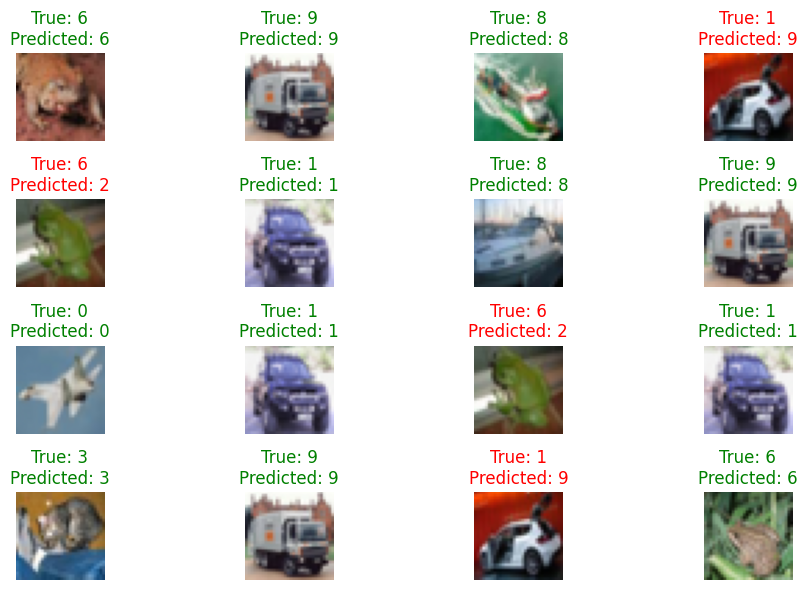

In [73]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 6))
random_index = np.random.randint(0, len(adv_test), 16)

for i, ax in enumerate(axes.ravel()):
    ax.imshow(adv_test[random_index[i]], cmap='gray')
    ax.axis('off')

    if y_test[random_index[i]] == adv_preds[random_index[i]]:
        color = 'green'
    else:
        color = 'red'

    ax.set_title(
        f'True: {y_test[random_index[i]]}\nPredicted: {adv_preds[random_index[i]]}',
        color=color
    )

plt.tight_layout()
plt.show()